In [27]:
import numpy as np
import pandas as pd
import warnings
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score,mean_squared_error
from transformers import DistilBertTokenizer, DistilBertModel
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt

# ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/upworthy-archive-confirmatory-packages-03.12.2020.csv',
                 usecols=['created_at','clickability_test_id','headline','impressions','clicks'])
df.head(3)

,created_at,clickability_test_id,headline,impressions,clicks
0,2014-11-20 11:33:26.475,546dd17e26714c82cc00001c,"Let’s See … Hire Cops, Pay Teachers, Buy Books...",3118,8
1,2014-11-20 15:00:01.032,546e01d626714c6c4400004e,People Sent This Lesbian Questions And Her Rai...,4587,130
2,2014-11-20 11:33:51.973,546dd17e26714c82cc00001c,$3 Million Is What It Takes For A State To Leg...,3017,19


In [2]:
df.info(),df.shape

NameError: name 'df' is not defined

In [31]:
import pandas as pd
from itertools import combinations

# read the CSV file and select columns of interest
df = pd.read_csv('../data/upworthy-archive-exploratory-packages-03.12.2020.csv', usecols=['created_at','clickability_test_id', 'headline', 'impressions', 'clicks'])

# create an empty DataFrame to store the results
final_df = pd.DataFrame(columns=['clickability_test_id', 'headline A', 'headline B', 'impressions A', 'impressions B', 'clicks A', 'clicks B'])

# group the DataFrame by clickability_test_id
grouped = df.groupby('clickability_test_id')

# iterate over each unique clickability_test_id
for test_id, group in grouped:
    # generate all possible pairs of headlines
    pairs = list(combinations(group['created_at'], 2))
    
    # iterate over each pair and compute the impressions and clicks for each headline
    for pair in pairs:
        impressions_A = group.loc[group['created_at'] == pair[0], 'impressions'].iloc[0]
        clicks_A = group.loc[group['created_at'] == pair[0], 'clicks'].iloc[0]
        impressions_B = group.loc[group['created_at'] == pair[1], 'impressions'].iloc[0]
        clicks_B = group.loc[group['created_at'] == pair[1], 'clicks'].iloc[0]
        headline_A = group.loc[group['created_at'] == pair[0], 'headline'].iloc[0]
        headline_B = group.loc[group['created_at'] == pair[1], 'headline'].iloc[0]
        
        # add the results to the final DataFrame
        final_df = final_df.append({'clickability_test_id': test_id,
                                    'headline A': headline_A,
                                    'headline B': headline_B,
                                    'impressions A': impressions_A,
                                    'impressions B': impressions_B,
                                    'clicks A': clicks_A,
                                    'clicks B': clicks_B}, ignore_index=True)

# display the final DataFrame
# print(final_df.tail())


In [32]:
final_df = final_df[(final_df['clicks A'] != 0) | (final_df['clicks B'] != 0)]

In [33]:
final_df.shape

(44798, 7)

In [34]:
final_df = final_df[final_df['headline A']!=final_df['headline B']]

In [35]:
final_df.head()

,clickability_test_id,headline A,headline B,impressions A,impressions B,clicks A,clicks B
0,51436061220cb800020001e7,Creationism Has Nothing To Do With Christianit...,The One Where A Creationist Picks A Fight And ...,2551,2629,39,68
1,51436061220cb800020001e7,Creationism Has Nothing To Do With Christianit...,Creationism Shouldn't Be Taught In Science Cla...,2551,2539,39,49
2,51436061220cb800020001e7,Creationism Has Nothing To Do With Christianit...,God Finds Out About Creationism And Sends A Re...,2551,2661,39,63
3,51436061220cb800020001e7,The One Where A Creationist Picks A Fight And ...,Creationism Shouldn't Be Taught In Science Cla...,2629,2539,68,49
4,51436061220cb800020001e7,The One Where A Creationist Picks A Fight And ...,God Finds Out About Creationism And Sends A Re...,2629,2661,68,63


In [36]:
final_df.shape

(21770, 7)

In [37]:
final_df['clickability_test_id'].nunique()

2607

Test statistics: Z - test
$$ t = \frac{(\bar{\pi_1} - \bar{\pi_2})}{\sqrt{\hat{\pi}(1-\hat{\pi})(\frac{1}{n_1}+\frac{1}{n_2})}} \sim N(0,1)$$
where,
$$ \hat{\pi} = \frac{n_1\hat{\pi_1}+n_2\hat{\pi_2}}{n_1+n_2} $$

We have normal distribution N(0,1)

Condition to check: $\pi_1>\pi_2$

In [38]:
n1 = final_df['impressions A']
n2 = final_df['impressions B']
pi1hat = final_df['clicks A']/n1
pi2hat = final_df['clicks B']/n2
pihat = (n1*pi1hat + n2*pi2hat) / (n1 + n2)
denom = pihat * (1-pihat) * (1/n1 + 1/n2)
denom = denom.astype(float)
t = (pi1hat - pi2hat) / np.sqrt(denom)
t=t.astype(float)
pv = stats.norm.cdf(t)
final_df['p_a_gte_b'] = pv
final_df.head()

,clickability_test_id,headline A,headline B,impressions A,impressions B,clicks A,clicks B,p_a_gte_b
0,51436061220cb800020001e7,Creationism Has Nothing To Do With Christianit...,The One Where A Creationist Picks A Fight And ...,2551,2629,39,68,0.003727
1,51436061220cb800020001e7,Creationism Has Nothing To Do With Christianit...,Creationism Shouldn't Be Taught In Science Cla...,2551,2539,39,49,0.136178
2,51436061220cb800020001e7,Creationism Has Nothing To Do With Christianit...,God Finds Out About Creationism And Sends A Re...,2551,2661,39,63,0.014438
3,51436061220cb800020001e7,The One Where A Creationist Picks A Fight And ...,Creationism Shouldn't Be Taught In Science Cla...,2629,2539,68,49,0.943685
4,51436061220cb800020001e7,The One Where A Creationist Picks A Fight And ...,God Finds Out About Creationism And Sends A Re...,2629,2661,68,63,0.695843


In [12]:
def build_bow_vectorizer(df):
    corpus = np.concatenate([df['headline A'].values,
                             df['headline B'].values])
    vectorizer = CountVectorizer(ngram_range=(1,2),
                                 lowercase=True,
                                 binary=True,
                                 max_df=0.6,
                                 min_df=0.005)
    vectorizer.fit(corpus)
    return vectorizer

In [13]:
bow_vector = build_bow_vectorizer(final_df)

In [14]:
features = bow_vector.get_feature_names()
corpuss = np.concatenate([final_df['headline A'].values,final_df['headline B'].values],axis=0)
bow = bow_vector.transform(corpuss)

In [15]:
bow.shape

(43540, 519)

We have 519 features and we have '1' if the feature is avaiable in headline

In [16]:
final_df.shape

(21770, 8)

In [17]:
corpuss[21770]

'The One Where A Creationist Picks A Fight And Loses To A Priest'

In [18]:
corpuss[4],corpuss[final_df.shape[0]+4]

('The One Where A Creationist Picks A Fight And Loses To A Priest',
 'God Finds Out About Creationism And Sends A Representative To Put A Stop To It')

Modelling difference between 2 headlines

In [19]:
# bow[0].toarray()

In [17]:
# headline_embedd=np.empty(final_df.shape[0],dtype='int')
headline_embedd=[]
for i in range(final_df.shape[0]):
    headline_embedd.append((bow[i]-bow[i+final_df.shape[0]]).toarray()[0])

In [18]:
# (bow[0]-bow[final_df.shape[0]]).toarray()[0]

In [19]:
headline_embedd = np.array(headline_embedd)
headline_embedd.shape

(21770, 519)

We have only 21k records which are having different headlines for exploratory csv.<br>
104k records in confirmatory csv.

In [20]:
def logit(p):
    return np.log(p / (1 - p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [21]:
# final_df[final_df['p_a_gte_b']==epsilon]

In [22]:
epsilon = 1e-8
# Update values in 'p_a_gte_b' column of final_df where condition is met
final_df.loc[final_df['p_a_gte_b'] == 1, 'p_a_gte_b'] = epsilon  #So that logit doesnt become inf

X=headline_embedd
Y=final_df['p_a_gte_b']
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [23]:
target_train = logit(y_train)

In [24]:
base_model = LinearRegression().fit(x_train, target_train)

In [25]:
y_pred = base_model.predict(x_test)
y_pred_pv = sigmoid(y_pred)
mse_bow = mean_squared_error(y_test,y_pred_pv)
mse_bow

0.16234364109562108

0.16234 - MSE from bow vectorization = exploratory data<br>
0.1562 - MSE from bow vectorization = confirmatory data

## Using sentence transformer instead of Distilbert last hidden state activation

In [37]:
## does the sentence transformer get the embedding with what words are in what position as it takes whole sentence. 
# hows it diffferent from tokenizer and model fit by distilbert

In [39]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
text_A = list(final_df['headline A'].values)
text_B = list(final_df['headline B'].values)

#Sentences are encoded by calling model.encode()
embeddings_A = model.encode(text_A,output_value='sentence_embedding',show_progress_bar=True)
embeddings_B = model.encode(text_B,output_value='sentence_embedding',show_progress_bar=True)

Batches:   0%|          | 0/3278 [00:00<?, ?it/s]

Batches:   0%|          | 0/3278 [00:00<?, ?it/s]

In [41]:
sent_headline_embedd = embeddings_A-embeddings_B

In [65]:
X=sent_headline_embedd
Y=final_df['p_a_gte_b']
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
target_train = logit(y_train)

In [66]:
base_model = LinearRegression().fit(x_train, target_train)

In [46]:
y_pred = base_model.predict(x_test)
y_pred_pv = sigmoid(y_pred)
mse_sentence_transformer = mean_squared_error(y_test,y_pred_pv)
mse_sentence_transformer

0.1507556584095765

In [67]:
mean_squared_error(logit(y_test),y_pred)

23.56126400542451

0.159 MSE with sentence transformer embeddings - exploratory<br>
0.150 MSE with sentence transformer embeddings - confirmatory


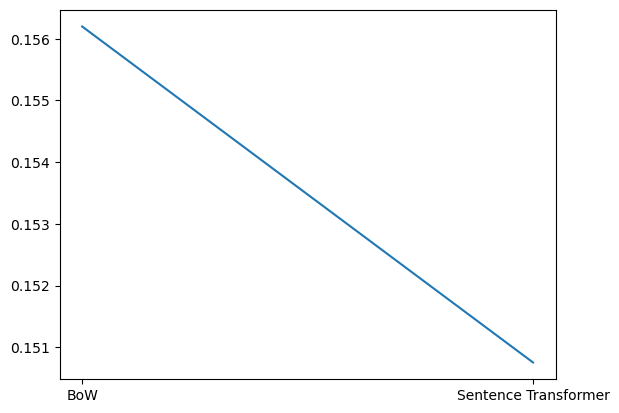

In [61]:
embedding_type = ['BoW','Sentence Transformer']
plt.plot(embedding_type,[mse_bow,mse_sentence_transformer])
plt.show()


In [29]:
# final_df['headline A'].values

In [62]:
# Load pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Example text input
text_A = list(final_df['headline A'].values)
text_B = list(final_df['headline B'].values)
# Tokenize text input
tokens = tokenizer(text_A,text_B,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
print(tokens['input_ids'].shape)

input_ids_a = tokens['input_ids'][0]
attention_mask_a = tokens['attention_mask'][0]
input_ids_b = tokens['input_ids'][1]
attention_mask_b = tokens['attention_mask'][1]
# print(tokens['input_ids'].shape)
# Pass tokens through DistilBERT model
# with torch.no_grad():
#     outputs = model(tokens['input_ids'], attention_mask=tokens['attention_mask'])
    
# # Extract the last hidden state activations
# last_hidden_state = outputs[0].squeeze().numpy()

# # Print the last hidden state activations
# print("Last Hidden State Activations:")
# print(last_hidden_state.shape)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([104866, 73])


In [30]:
# tokens['input_ids'].shape

In [31]:
final_df.shape

(104866, 8)

In [32]:
# def build_disbert_vectorizer(df):
#     tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#     model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    
#     text_A = list(final_df['headline A'].values)
#     text_B = list(final_df['headline B'].values)
#     # Tokenize text input
#     tokens = tokenizer(text_A,text_B,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
#     print(tokens['input_ids'].shape)
    
#     input_ids_a = tokens['input_ids'][0]
#     attention_mask_a = tokens['attention_mask'][0]
#     input_ids_b = tokens['input_ids'][1]
#     attention_mask_b = tokens['attention_mask'][1]
#     # Pass tokens through DistilBERT model
#     with torch.no_grad():
#         outputs_A = model(input_ids_a, attention_mask=attention_mask_a)
#         outputs_B = model(input_ids_b, attention_mask=attention_mask_b)
#     # Extract the last hidden state activations
#     last_hidden_state_A = outputs_A[0].squeeze().numpy()
#     last_hidden_state_B = outputs_B[0].squeeze().numpy()
    
#     # Print the last hidden state activations
#     print("Last Hidden State Activations:")
#     print(last_hidden_state_A.shape,last_hidden_state_B.shape)
#     return last_hidden_state_A,last_hidden_state_B
    

In [33]:
# input_ids_b

In [34]:
# dis_embed_A,dis_embed_B = build_disbert_vectorizer(final_df)

In [44]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

text_A = list(final_df['headline A'].values)
text_B = list(final_df['headline B'].values)
# Tokenize text input
tokens_A = tokenizer(text_A,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
tokens_B = tokenizer(text_B,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
# print(tokens['input_ids'].shape)

# input_ids_a = tokens['input_ids'][0]
# attention_mask_a = tokens['attention_mask'][0]
# input_ids_b = tokens['input_ids'][1]
# attention_mask_b = tokens['attention_mask'][1]
# Pass tokens through DistilBERT model
with torch.no_grad():
    OP_A = model(tokens_A['input_ids'], attention_mask=tokens_A['attention_mask'])
    OP_B = model(tokens_B['input_ids'], attention_mask=tokens_B['attention_mask'])
# Extract the last hidden state activations
last_hidden_state_a = OP_A[:,0].numpy()
last_hidden_state_b = OP_B[:,0].numpy()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

In [1]:
tokens_A['input_ids'].shape,tokens_B['input_ids'].shape

NameError: name 'tokens_A' is not defined

In [46]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Move model to GPU
model = model.to('cuda')

text_A = list(final_df['headline A'].values)
text_B = list(final_df['headline B'].values)
# Tokenize text input
tokens_A = tokenizer(text_A,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
tokens_B = tokenizer(text_B,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')

# Move tokenized inputs to GPU
tokens_A = {k:v.to('cuda') for k, v in tokens_A.items()}
tokens_B = {k:v.to('cuda') for k, v in tokens_B.items()}

# Pass tokens through DistilBERT model
with torch.no_grad():
    OP_A = model(tokens_A['input_ids'], attention_mask=tokens_A['attention_mask'])
    OP_B = model(tokens_B['input_ids'], attention_mask=tokens_B['attention_mask'])

# Move output tensors back to CPU and convert to numpy arrays
last_hidden_state_a = OP_A[:,0].cpu().numpy()
last_hidden_state_b = OP_B[:,0].cpu().numpy()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(1, 768)

In some cases, the first token (often referred to as the "[CLS]" token) may contain important contextual information that summarizes the entire input text, especially when fine-tuned on a specific task. This is because in models like DistilBERT, the "[CLS]" token is used as a special token to represent the entire sequence during pre-training, and during fine-tuning it can be used to capture task-specific information

In [47]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# text_A = list(final_df['headline A'].values)
# text_B = list(final_df['headline B'].values)
text_A = "This is test text to check how thte shape comes out"
# Tokenize text input
tokens_A = tokenizer(text_A,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
# tokens_B = tokenizer(text_B,padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')
# print(tokens['input_ids'].shape)

# input_ids_a = tokens['input_ids'][0]
# attention_mask_a = tokens['attention_mask'][0]
# input_ids_b = tokens['input_ids'][1]
# attention_mask_b = tokens['attention_mask'][1]
# Pass tokens through DistilBERT model
with torch.no_grad():
    OP_A = model(tokens_A['input_ids'], attention_mask=tokens_A['attention_mask']).last_hidden_state
    # OP_B = model(tokens_B['input_ids'], attention_mask=tokens_B['attention_mask'])
# Extract the last hidden state activations
last_hidden_state_a = OP_A[:,0].numpy()
# last_hidden_state_b = OP_B[:,0].numpy()
last_hidden_state_a.shape

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TypeError: tuple indices must be integers or slices, not tuple